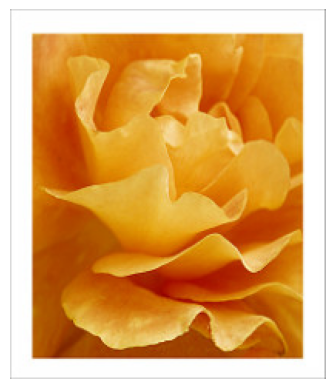

In [1]:
from PIL import Image
import matplotlib.pyplot as plt

image_path = '/home/slakkaraju/flowers/flowers/534228982_4afbcece9b_m.jpg'
image = Image.open(image_path).convert("RGB")

plt.imshow(image)
plt.axis('off')  # hide axes
plt.show()


In [4]:
from transformers import BlipProcessor, BlipForConditionalGeneration
from PIL import Image
import torch

device = 'cpu'

# Load BLIP model
processor_blip = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
model_blip = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base").to(device)

def generate_caption_blip(image_path):
    image = Image.open(image_path).convert("RGB")
    inputs = processor_blip(images=image, return_tensors="pt").to(device)
    out = model_blip.generate(**inputs)
    return processor_blip.decode(out[0], skip_special_tokens=True)


Fetching 1 files: 100%|██████████| 1/1 [00:00<00:00, 12826.62it/s]


In [5]:
# Example flower image path
image_path = '/home/slakkaraju/flowers/flowers/534228982_4afbcece9b_m.jpg'

# Generate caption from image
caption = generate_caption_blip(image_path)
print("BLIP Caption:", caption)

BLIP Caption: a yellow rose flower with a white background


In [2]:
from transformers import Blip2Processor, Blip2ForConditionalGeneration
from PIL import Image
import torch

device = 'cpu' #torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load BLIP-2 model and processor
processor_blip2 = Blip2Processor.from_pretrained("Salesforce/blip2-flan-t5-xl")
model_blip2 = Blip2ForConditionalGeneration.from_pretrained("Salesforce/blip2-flan-t5-xl").to(device)

def generate_caption(image_path):
    image = Image.open(image_path).convert("RGB")
    inputs = processor_blip2(images=image, text="What is in this image?", return_tensors="pt").to(device)
    generated_ids = model_blip2.generate(**inputs)
    caption = processor_blip2.decode(generated_ids[0], skip_special_tokens=True)
    return caption


/home/slakkaraju/flowers/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
Loading checkpoint shards: 100%|██████████| 2/2 [00:00<00:00,  4.64it/s]


In [3]:
# Example flower image path
image_path = '/home/slakkaraju/flowers/flowers/534228982_4afbcece9b_m.jpg'

# Generate caption from image
caption = generate_caption(image_path)
print("BLIP-2 Caption:", caption)

BLIP-2 Caption: a yellow rose


In [6]:
from transformers import CLIPProcessor, CLIPModel
from PIL import Image
import torch

device = 'cpu'

# Load CLIP model
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

def classify_with_clip(image_path, candidate_labels):
    image = Image.open(image_path).convert("RGB")
    inputs = clip_processor(text=candidate_labels, images=image, return_tensors="pt", padding=True).to(device)
    outputs = clip_model(**inputs)
    logits_per_image = outputs.logits_per_image  # similarity scores
    probs = logits_per_image.softmax(dim=1)
    return {label: probs[0][i].item() for i, label in enumerate(candidate_labels)}


Fetching 1 files: 100%|██████████| 1/1 [00:00<00:00, 10672.53it/s]


In [7]:
# Example flower image path
image_path = '/home/slakkaraju/flowers/flowers/534228982_4afbcece9b_m.jpg'
candidate_labels = ["a flower", "a rose", "a chair", "a dog"]

# Generate caption from image
caption = classify_with_clip(image_path, candidate_labels)
print("CLIP Classification:", caption)

CLIP Classification: {'a flower': 0.2115204930305481, 'a rose': 0.7879067063331604, 'a chair': 0.00040460930904373527, 'a dog': 0.00016815935669001192}


In [8]:
from transformers import ViTImageProcessor, ViTForImageClassification
from PIL import Image
import torch

device = 'cpu'

# Load ViT
processor_vit = ViTImageProcessor.from_pretrained("google/vit-base-patch16-224")
model_vit = ViTForImageClassification.from_pretrained("google/vit-base-patch16-224").to(device)

def classify_with_vit(image_path):
    image = Image.open(image_path).convert("RGB")
    inputs = processor_vit(images=image, return_tensors="pt").to(device)
    outputs = model_vit(**inputs)
    logits = outputs.logits
    predicted_class_id = logits.argmax(-1).item()
    return model_vit.config.id2label[predicted_class_id]


Fetching 1 files: 100%|██████████| 1/1 [00:00<00:00, 13148.29it/s]

In [9]:
# Example flower image path
image_path = '/home/slakkaraju/flowers/flowers/534228982_4afbcece9b_m.jpg'

# Generate caption from image
caption = classify_with_vit(image_path)
print("VIT Classification:", caption)

VIT Classification: vase


In [10]:
import ollama

client = ollama.Client(host="http://127.0.0.1:11434")

# Get available models
models_info = client.list()

# Print to see structure
print(models_info)


models=[Model(model='llava:7b', modified_at=datetime.datetime(2025, 9, 3, 22, 31, 56, 376341, tzinfo=TzInfo(-07:00)), digest='8dd30f6b0cb19f555f2c7a7ebda861449ea2cc76bf1f44e262931f45fc81d081', size=4733363377, details=ModelDetails(parent_model='', format='gguf', family='llama', families=['llama', 'clip'], parameter_size='7B', quantization_level='Q4_0'))]


In [14]:
import base64
from io import BytesIO
from PIL import Image
import ollama

client = ollama.Client(host="http://127.0.0.1:11434")

def describe_image(image_path, model_name="llava:7b"):
    # --- Load image and convert to base64 ---
    image = Image.open(image_path).convert("RGB")
    buffered = BytesIO()
    image.save(buffered, format="JPEG")
    img_base64 = base64.b64encode(buffered.getvalue()).decode("utf-8")

    # --- Ask LLaVA ---
    prompt = "Describe this image in detail."
    response = client.chat(
        model=model_name,
        messages=[{
            "role": "user",
            "content": prompt,
            "images": [img_base64]
        }]
    )

    return response["message"]["content"]


In [15]:
image_path = '/home/slakkaraju/flowers/flowers/534228982_4afbcece9b_m.jpg'  # replace with your local image
description = describe_image(image_path, model_name="llava:7b")
print("LLaVA response:", description)

LLaVA response:  The image captures a vibrant scene of a flower. The flower, a large bloom with orange petals, is the central focus of the image. The petals are arranged in layers and have a slightly curled appearance, adding a dynamic element to the composition. 

The flower's center is visible and features a light-colored pattern that contrasts beautifully with the orange petals. 

In addition to the floral subject, there's also an envelope present in the image. The envelope has a beige background and displays a photograph of a flower, suggesting that this could be a postcard or card featuring the flower from the image. 

The entire scene is set against a neutral gray background, which serves to highlight the colors within the image. The relative position of the objects suggests that they are placed on a flat surface, possibly for display or photography purposes. There's no text visible in the image. The overall composition of the image places emphasis on the beauty and detail of the